In [1]:
import os,sys
sys.path.append('./hmvec-master/')
import hmvec as hm # Git clone and pip install as in readme from github.com/msyriac/hmvec
from compute_power_spectra import *
from plotting import *
from params import *

np_load_old = np.load
np.load     = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)


In [2]:
ellMax = 9600
ells = np.arange(ellMax)
ellss = np.arange(6500)

mm = 30
mmm = 5000

nMs = 100
cmap1 = get_cmap(len(dictKey)+3)

baseline = ghztoev(30)

ztype = [2., 6., 10.]


In [3]:
avtaulist = np.zeros((len(ztype), len(dictKey))) 
tauMWlist = np.zeros(len(dictKey))
dtaudzlist, zsList = np.zeros((2, len(ztype), len(dictKey), 50))
Cell1Hdata, Cell2Hdata, CellTauTau = np.zeros((3, len(ztype), len(dictKey), ellMax))
Screening, Screening2  = np.zeros((2, len(ztype), len(dictKey), 4, ellMax))
Survey_z6, Survey_z10 = np.zeros((2, len(dictKey), ellMax))

for mind, MA in enumerate(dictKey):
    for zind, ztest in enumerate(ztype):
        
        if mind > 11:
            rscale = False
        else:
            rscale = True

        nZs, zMin, zMax, rMin, rMax, mMin, mMax = chooseModel(MA, modelParams)
        nZs = int(nZs)
        zMax = min(ztest, zMax)

        data = import_data(MA, nZs, zMin, zMax, ellMax, rscale=rscale)
        if data==None:
            print(zMax, MA, rscale, ztest, ' skipped!')
            continue
        rcross, prob, avtau, dtaudz, rcrossMW, probMW, uell0, Cell1H, Cell2H, CMBDP, CMBDP2 = data

        zsList[zind, mind]     = np.linspace(zMin,zMax,nZs)

        avtaulist[zind, mind]  = avtau/baseline
        dtaudzlist[zind, mind] = dtaudz/baseline
        if ztest==6.:
            tauMWlist[mind] = probMW/baseline

        Cell1Hdata[zind, mind] = Cell1H
        Cell2Hdata[zind, mind] = Cell2H
        
        CellTauTau[zind, mind] = avtaulist[zind, mind]**2. * (Cell1H + Cell2H)
        
        Screening[zind, mind]  = avtaulist[zind, mind]**2. * CMBDP
        Screening2[zind, mind] = avtaulist[zind, mind]**2. * CMBDP2

for mind, MA in enumerate(dictKey):
    Survey_z6[mind]  = avtaulist[1, mind]**2. * (Cell1Hdata[0, mind] + Cell2Hdata[0, mind])
    Survey_z10[mind] = avtaulist[2, mind]**2. * (Cell1Hdata[0, mind] + Cell2Hdata[0, mind])


In [4]:
ms   = np.geomspace(mMin,mMax,nMs)          # masses
zs   = np.linspace(zMin,zMax,nZs)           # redshifts
ks   = np.geomspace(1e-4,1e3,1001)          # wavenumbers

print('Creating Halo Model.')
hcos = hm.HaloModel(zs, ks, ms, mass_function='tinker', mdef='vir')

print('Importing base CMB PS and adding T monopole.')
CMB_ps        = hcos.CMB_power_spectra()
unlenCMB      = CMB_ps['unlensed_scalar']
unlenCMB      = unlenCMB[:ellMax, :]
unlenCMB[0,0] = TCMB**2.
lensedCMB     = CMB_ps['lensed_scalar']
lensedCMB     = lensedCMB[:ellMax, :]
lensedCMB[0,0]= TCMB**2.


Creating Halo Model.
Importing base CMB PS and adding T monopole.


In [5]:
print(len(dictKey))

masslist_old = dictKey

ff6 = interpolate.interp1d(masslist_old, avtaulist[1], kind='quadratic')
ff10 = interpolate.interp1d(masslist_old, avtaulist[2], kind='quadratic')
fftau = interpolate.interp1d(masslist_old, tauMWlist, kind='quadratic')

masslist = np.linspace(masslist_old[0], masslist_old[-1], 1000)


24


In [6]:
print(np.shape(avtaulist))

np.save('./data/nor0_taubar_zmax6.npy', np.asarray([dictKey, avtaulist[1,:]]))
np.save('./data/nor0_taubar_zmax10.npy', np.asarray([dictKey, avtaulist[2,:]]))

np.save('./data/nor0_taubar_total_zmax6.npy', np.asarray([dictKey, avtaulist[1,:]+tauMWlist]))
np.save('./data/nor0_taubar_total_zmax10.npy', np.asarray([dictKey, avtaulist[2,:]+tauMWlist]))

np.save('./data/nor0_interp_taubar_zmax6.npy', np.asarray([masslist, ff6(masslist)]))
np.save('./data/nor0_interp_taubar_zmax10.npy', np.asarray([masslist, ff10(masslist)]))

np.save('./data/nor0_interp_total_taubar_zmax6.npy', np.asarray([masslist, ff6(masslist)+fftau(masslist)]))
np.save('./data/nor0_interp_total_taubar_zmax10.npy', np.asarray([masslist, ff10(masslist)+fftau(masslist)]))


(3, 24)


In [7]:
MAMWlimit = np.load('./data/MWmassconstraint.npy')
MAMW_rscalelimit = np.load('./data/MWrscale_massconstraint.npy')
rscaleMW = np.load('./data/MWscaleradius.npy')


In [8]:
if False:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):

        leftoverdata = np.zeros((len(ztype), len(dictKey), 3, ellMax))
        for zind, ztest in enumerate(ztype):
            for mind, MA in enumerate(dictKey):
                epsilon = 1e-8
                recombination = unlenCMB
                screening = epsilon**4. * Screening[zind, mind]
                leftoverdata[zind, mind] = get_ILC_noise(ells, 5000, baseline, screening, recombination, experiment)

        np.save(nor0_ILCnoisePS_path(expname), leftoverdata)


/home/dpirvu/DarkPhoton/compute_power_spectra.py:221: RuntimeWarning: divide by zero encountered in divide
  WNoise = deltaT[frq] * ( 1. + (ells[2:]/lknee[frq])**aknee[frq] )
/home/dpirvu/DarkPhoton/compute_power_spectra.py:222: RuntimeWarning: overflow encountered in exp
  NellTT[2:, frq] = WNoise * np.exp(Beam)


In [9]:
if False:
    for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):

        leftoverdata = np.zeros((len(ztype), len(dictKey), 3, ellMax))
        for zind, ztest in enumerate(ztype):
            for mind, MA in enumerate(dictKey):
                epsilon = 1e-8
                recombination = lensedCMB
                screening = epsilon**4. * Screening[zind, mind]
                leftoverdata[zind, mind] = get_ILC_noise(ells, 5000, baseline, screening, recombination, experiment)

        np.save(len_nor0_ILCnoisePS_path(expname), leftoverdata)


In [10]:
# test forecast
if True:
    mind = 10
    expname = 'Planck'
    ILCnoise = np.load(nor0_ILCnoisePS_path(expname))

    reconoise_z6  = np.load(reconoisePS_path(expname, 6))
    reconoise_z10  = np.load(reconoisePS_path(expname, 10))

    leftover_z6,  leftover_z10  = ILCnoise[1, mind, :, ells], ILCnoise[2, mind, :, ells]
    screening_z6, screening_z10 = Screening[1, mind, :, ells], Screening[2, mind, :, ells]
    template_z6,  template_z10  = Survey_z6[mind, ells], Survey_z10[mind, ells]

    
    sigmaFidMF1 = sigma_screening(0., mm, mmm, screening_z6, leftover_z6)
    sigmaFidMF2 = sigma_screening(0., mm, mmm, screening_z10, leftover_z10)

    sigmaFidMF3 = sigma_screeningVtemplate(TCMB, 0., mm, mmm, screening_z6, leftover_z6, template_z6)
    sigmaFidMF4 = sigma_screeningVtemplate(TCMB, 0., mm, mmm, screening_z10, leftover_z10, template_z10)

    sigmaFidMF5 = sigma_recoVtemplate(TCMB, 0., mm, mmm, template_z6[ellss], reconoise_z6[ellss], template_z6[ellss])
    sigmaFidMF6 = sigma_recoVtemplate(TCMB, 0., mm, mmm, template_z10[ellss], reconoise_z10[ellss], template_z10[ellss])

    print(sigmaFidMF1, sigmaFidMF2)
    print(sigmaFidMF3, sigmaFidMF4)
    print(sigmaFidMF5, sigmaFidMF6)


1.1371448664360855e-10 1.1371448664360855e-10
1.644666888651974e-11 1.644666888651974e-11
1.7654319017778244e-11 1.7654319017778244e-11


In [11]:
sigmaEpsilonList = np.ones((2, len(dictKey), 3, 2)) # (#reionization start, #masses sampled, #experiments sampled, #forecast methods)

for mind, MA in enumerate(dictKey):
    for eind, (expname, experiment) in enumerate(zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD])):
        if expname=='Planck':
            mm = 2
            mmm = 5000
        else:
            mm = 30
            mmm = 5000

        ILCnoise = np.load(nor0_ILCnoisePS_path(expname))
        reconoise_z6 = np.load(reconoisePS_path(expname, 6))
        reconoise_z10 = np.load(reconoisePS_path(expname, 10))

        leftover_z6 = ILCnoise[1, mind, :, ells]
        leftover_z10 = ILCnoise[2, mind, :, ells]

        screening_z6 = Screening[1, mind, :, ells]
        screening_z10 = Screening[2, mind, :, ells]

        template_z6 = Survey_z6[mind, ells]
        template_z10 = Survey_z10[mind, ells]

        # get constraint with different covariant matrices
        # first constraint: CMB screening
        sigmaEpsilonList[0, mind, eind, 0] = sigma_screening(0., mm, mmm, screening_z6, leftover_z6)
        sigmaEpsilonList[1, mind, eind, 0] = sigma_screening(0., mm, mmm, screening_z10, leftover_z10)    

        # Third constraint: CMB screening cross correlated wih template
        sigmaEpsilonList[0, mind, eind, 1] = sigma_screeningVtemplate(TCMB, 0., mm, mmm, screening_z6, leftover_z6, template_z6)
        sigmaEpsilonList[1, mind, eind, 1] = sigma_screeningVtemplate(TCMB, 0., mm, mmm, screening_z10, leftover_z10, template_z10)

        # third constraint: template cross correlated with reconstruction
 #       sigmaEpsilonList[0, mind, eind, 2] = sigma_recoVtemplate(TCMB, 0., mm, mmm, template_z6[ellss], reconoise_z6[ellss], template_z6[ellss])
 #       sigmaEpsilonList[1, mind, eind, 2] = sigma_recoVtemplate(TCMB, 0., mm, mmm, template_z10[ellss], reconoise_z10[ellss], template_z10[ellss])

    if mind==0:
        sigmaEpsilonList[:, mind, :, :] = 1e-2

## Plots

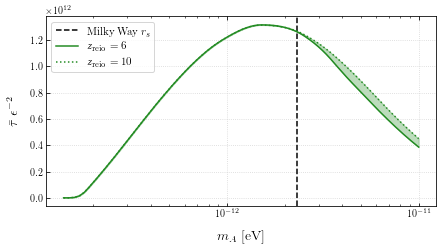

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
#plt.axvline(MAMWlimit, ls=':', color='k', alpha=1)
plt.axvline(MAMW_rscalelimit, ls='--', color='k', alpha=1, label=r'${\rm Milky \, Way} \; r_{s} $')
plt.grid(ls=':', color='lightgray', alpha=1)

#plt.plot(masslist, fftau(masslist), color='k', label=r'Milky Way', ls='-')

#plt.fill_between(dictKey, avtaulist[1,:], avtaulist[2,:], color=cmap1(1), alpha=0.7, label=r'Halo Model')
#plt.plot(dictKey, avtaulist[0,:], color=cmap1(1), alpha=1)
#plt.plot(dictKey, avtaulist[1,:], color=cmap1(1), alpha=1)
#plt.plot(dictKey, avtaulist[2,:], color=cmap1(1), alpha=1)

ind=4
#plt.fill_between(dictKey, nors_avtaulist[1,:], nors_avtaulist[2,:], color=cmap1(ind), alpha=0.7, label=r'Halo Model')
#plt.plot(dictKey, nors_avtaulist[0,:], color=cmap1(ind), alpha=1)
#plt.plot(dictKey, nors_avtaulist[1,:], color=cmap1(ind), alpha=1)
#plt.plot(dictKey, nors_avtaulist[2,:], color=cmap1(ind), alpha=1)

plt.fill_between(masslist, ff6(masslist), ff10(masslist), color='forestgreen', alpha=0.3)
plt.plot(masslist, ff6(masslist), color='forestgreen', ls='-', label=r'$z_{\rm reio}=6$')
plt.plot(masslist, ff10(masslist), color='forestgreen', ls=':', label=r'$z_{\rm reio}=10$')

#plt.xlim((1.35e-13, 9e-12))
plt.ylabel(r'$\bar{\tau} \; \epsilon^{-2}$')
plt.xlabel(r'$m_A \; [{\rm eV}]$')
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")
plt.xscale('log')
#plt.yscale('log')
plt.legend(loc=2)
#plt.savefig('./plots/monopoles.pdf', rasterize=True)
plt.show()

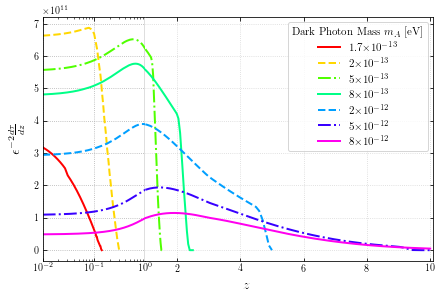

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))
divider = make_axes_locatable(ax)
axLin = divider.append_axes("right", size=4., pad=0)#, sharey=ax)
lines = cycle(['-', '--', '-.'])

xcap = 1
cmap2 = get_cmap(8)
iict = 0

ax.grid(ls=':', color='darkgray', alpha=1)
axLin.grid(ls=':', color='darkgray', alpha=0.5)
ax.axvline(xcap, ls='-', color='darkgray', alpha=0.5)

for mind, MA in enumerate(dictKey):
    if mind<2: continue
    elif mind%3==0:
        zs1 = zsList[1, mind]
        zs2 = zsList[2, mind]
        dat1 = dtaudzlist[1, mind]
        dat2 = dtaudzlist[2, mind]

        zsold = np.concatenate((zs1[zs1<=6.], zs2[zs2>6.]))
        dataold = np.concatenate((dat1[zs1<=6.], dat2[zs2>6.]))
        fint = interpolate.interp1d(zsold, dataold, kind='linear')
        zsnew = np.linspace(zsold[0], zsold[-1], 10000)

     #   lab = r'$m_A=${}'.format(fmt(MA))+r'eV'
        indmax = np.argmax(fint(zsnew))+50
        #lab1 = (r'$m_A=${}'.format(fmt(MA))+str(mind)+r'${\rm \; eV}$' if zsnew[indmax]<=xcap else None)
        #lab2 = (r'$m_A=${}'.format(fmt(MA))+str(mind)+r'${\rm \; eV}$' if zsnew[indmax]>xcap else None)
        lab2 = r'{}'.format(fmt(MA))
    #    lab2 = r'{}'.format(fmt(MA/1e-13))
        lss = next(lines)
        alp = 0.3

        ax.plot(zsnew[(zsnew<=xcap)&(fint(zsnew)>0)], fint(zsnew)[(zsnew<=xcap)&(fint(zsnew)>0)], color=cmap2(iict), ls=lss, linewidth=2)

        if mind<20:
            axLin.plot(zsnew[(zsnew>=xcap-1)], fint(zsnew)[(zsnew>=xcap-1)], color=cmap2(iict), label=lab2, ls=lss, linewidth=2)
        else:
            axLin.plot(zsnew[(zsnew>=xcap-1)&(fint(zsnew)>1)], fint(zsnew)[(zsnew>=xcap-1)&(fint(zsnew)>1)], color=cmap2(iict), label=lab2, ls=lss, linewidth=2)

        #annot_max(zsnew[indmax], f(zsnew)[indmax], lab, cmap2(iict), xcap, mind, \
        #ax=(ax if zsnew[indmax]<xcap else axLin))
        iict += 1
#labelLines(ax.get_lines(), align=False, xvals=np.geomspace(0.01, xcap, ct1))
#labelLines(axLin.get_lines(), align=False, xvals=np.linspace(xcap+1, 10, ct2))
ax.set_ylabel(r'$\epsilon^{-2} \frac{d \tau}{d z}$')
axLin.set_xlabel(r'$z$')

plt.setp(axLin.get_xticklabels(), visible=True)
plt.setp(ax.get_yticklabels(), visible=True)
axLin.xaxis.set_label_coords(0.35, -.07)

ytickslocs = ax.get_yticks()
axLin.axes.yaxis.set_ticklabels([])
axLin.axes.get_yaxis().set_ticks(ytickslocs)
ymin, ymax = ax.get_ylim()
axLin.set_ylim((ymin, ymax))
    
#axLin.legend(ncol=3, title=r'${\rm Dark \; Photon \; Mass} \; m_A \; [10^{-13}{\rm eV}]$')
axLin.legend(ncol=1, title=r'${\rm Dark \; Photon \; Mass} \; m_A \; [{\rm eV}]$')
ax.set_xlim((0.01, int(xcap))); axLin.set_xlim((int(xcap), 10.1))
ax.set_xscale('log'); axLin.set_xscale('linear')
ax.spines['right'].set_visible(False); axLin.spines['left'].set_visible(False)
ax.yaxis.set_ticks_position('left'); axLin.yaxis.set_ticks_position('right')
ax.xaxis.set_ticks_position('both'); axLin.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
axLin.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")
axLin.tick_params(which='both', axis="x", direction="in")

#plt.savefig('./plots/dtaudz.pdf', rasterize=True); plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


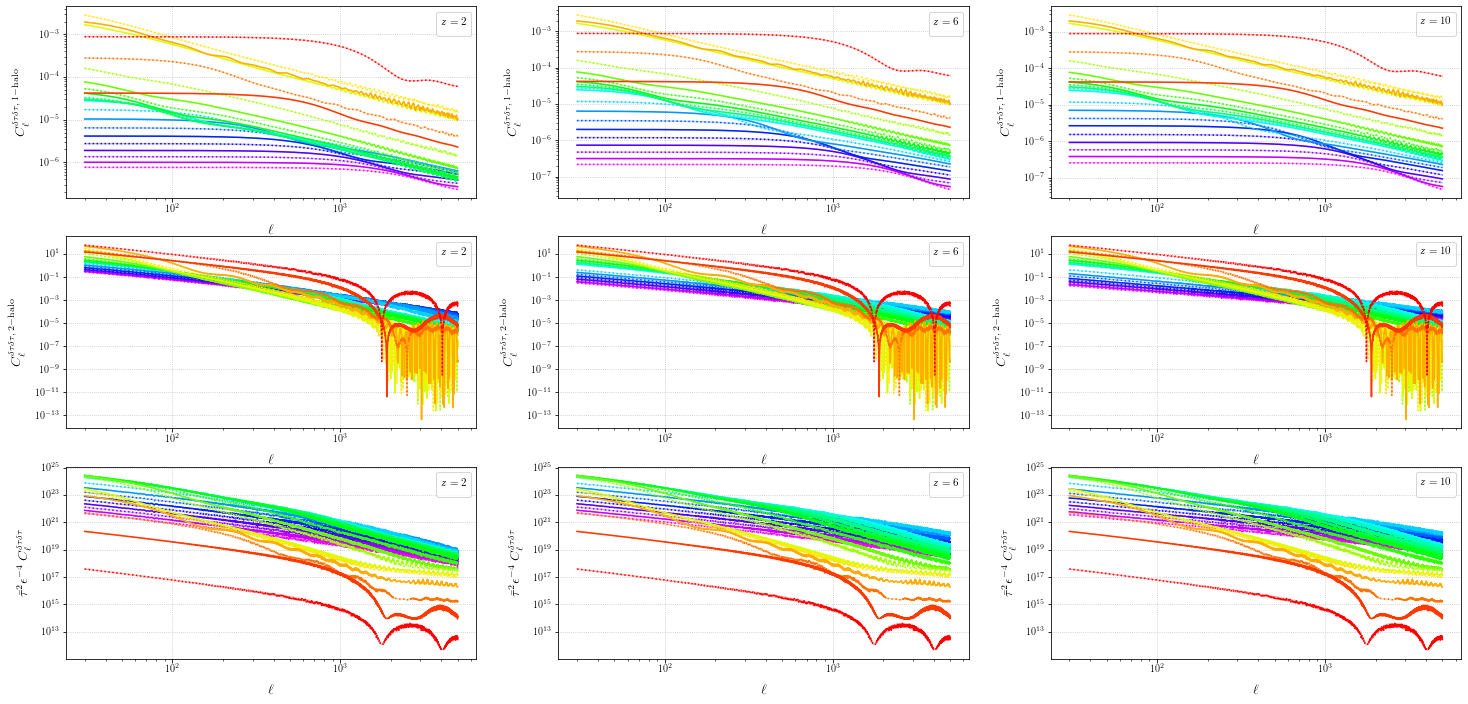

In [14]:
fig, ax = plt.subplots(3, len(ztype), figsize=(25, 12))
label_list = [r'$C_\ell^{\delta\tau\delta\tau, \; 1-{\rm halo}}$',\
              r'$C_\ell^{\delta\tau\delta\tau, \; 2-{\rm halo}}$',\
              r'$C_\ell^{\delta\tau\delta\tau}$']
for zind, ztest in enumerate(ztype):
    lines = cycle(['-', ':'][::-1])

    for mind, MA in reversed(list(enumerate(dictKey))):
        lab1 = r'{}'.format(fmt(MA))
        lss = next(lines)
        alp = 0.3

        ax[0, zind].plot(ells[mm:mmm], Cell1Hdata[zind, mind, mm:mmm], color=cmap1(mind-1), alpha=alp)
        ax[0, zind].plot(ells[mm:mmm], Cell1Hdata[zind, mind, mm:mmm], color=cmap1(mind-1), ls=lss)

        ax[1, zind].plot(ells[mm:mmm], Cell2Hdata[zind, mind, mm:mmm], color=cmap1(mind-1), alpha=alp)
        ax[1, zind].plot(ells[mm:mmm], Cell2Hdata[zind, mind, mm:mmm], color=cmap1(mind-1), ls=lss)

        ax[2, zind].plot(ells[mm:mmm], CellTauTau[zind, mind, mm:mmm], color=cmap1(mind-1), alpha=alp)
        ax[2, zind].plot(ells[mm:mmm], CellTauTau[zind, mind, mm:mmm], color=cmap1(mind-1), ls=lss)

for zind, ztest in enumerate(ztype):
    for aa, axx in enumerate(ax[:,zind]):
  #      axx.legend(ncol=3, title=r'${\rm Dark \; Photon \; Mass} \; m_A \; [{\rm eV}]$')
        axx.legend(title=r'$z=%5.0f$'%(int(ztest)))
        axx.set_xlabel(r'$\ell$')
        axx.set_ylabel((r'$\bar{\tau}^2 \epsilon^{-4}$ ' if aa==2 else ' ') + label_list[aa])
        axx.set_xscale('log'); axx.set_yscale('log')
        axx.grid(ls=':', color='gray', alpha=0.5)
#plt.savefig('./plots/celltautaufullgrid.pdf', rasterize=True)
plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


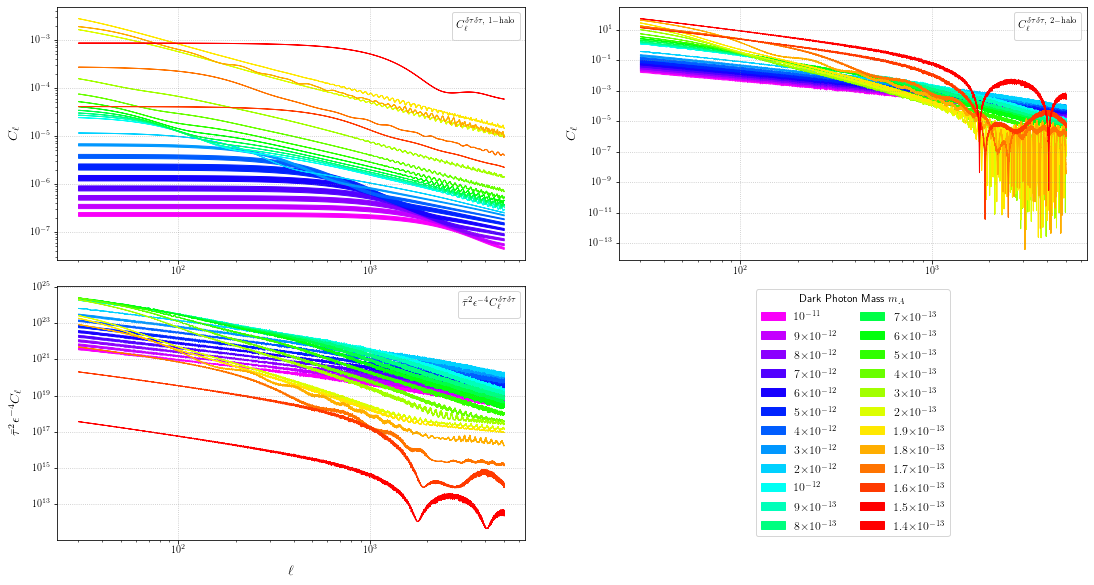

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
plt.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)
plt.subplots_adjust(hspace=.1)
plt.subplots_adjust(wspace=.2)

for mind, MA in reversed(list(enumerate(dictKey))):
  #  if mind<2: continue
  #  elif mind%3==0:
        lab1 = r'{}'.format(fmt(MA))
        alp = 0.3

        ax[0,0].fill_between(ells[mm:mmm], Cell1Hdata[1, mind, mm:mmm], Cell1Hdata[2, mind, mm:mmm], color=cmap1(mind-1))
        ax[0,1].fill_between(ells[mm:mmm], Cell2Hdata[1, mind, mm:mmm], Cell2Hdata[2, mind, mm:mmm], color=cmap1(mind-1))
        ax[1,0].fill_between(ells[mm:mmm], CellTauTau[1, mind, mm:mmm], CellTauTau[2, mind, mm:mmm], color=cmap1(mind-1))
        ax[1,1].fill_between(ells[mm:mmm], CellTauTau[1, mind, mm:mmm], CellTauTau[2, mind, mm:mmm], color=cmap1(mind-1), label=lab1)

    #    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    #    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

ax[1,1].legend(fontsize=12, loc='center', ncol=2, title=r'Dark Photon Mass $m_A$')
ax[1,1].set_xscale('log', subsx=[])
ax[1,1].set_yscale('log', subsy=[])
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['left'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['bottom'].set_visible(False)
ax[1,1].axes.yaxis.set_ticklabels([])
ax[1,1].axes.xaxis.set_ticklabels([])
ax[1,1].set_ylim((1.1e50, 2e50))
ax[1,1].set_xlim((1.1e50, 2e50))

for aa, axx in enumerate(ax.flatten()[:-1]):
    axx.legend(title=(r'$\bar{\tau}^2 \epsilon^{-4}$' if aa==2 else ' ')+label_list[aa])
    axx.set_xlabel(r'$\ell$')
    axx.set_ylabel((r'$\bar{\tau}^2 \epsilon^{-4} C_{\ell}$' if aa==2 else r'$C_{\ell}$'))
    axx.set_xscale('log')
    axx.set_yscale('log')
    axx.grid(ls=':', color='gray', alpha=0.5)
#plt.savefig('./plots/celltautau.pdf', rasterize=True)
plt.show()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


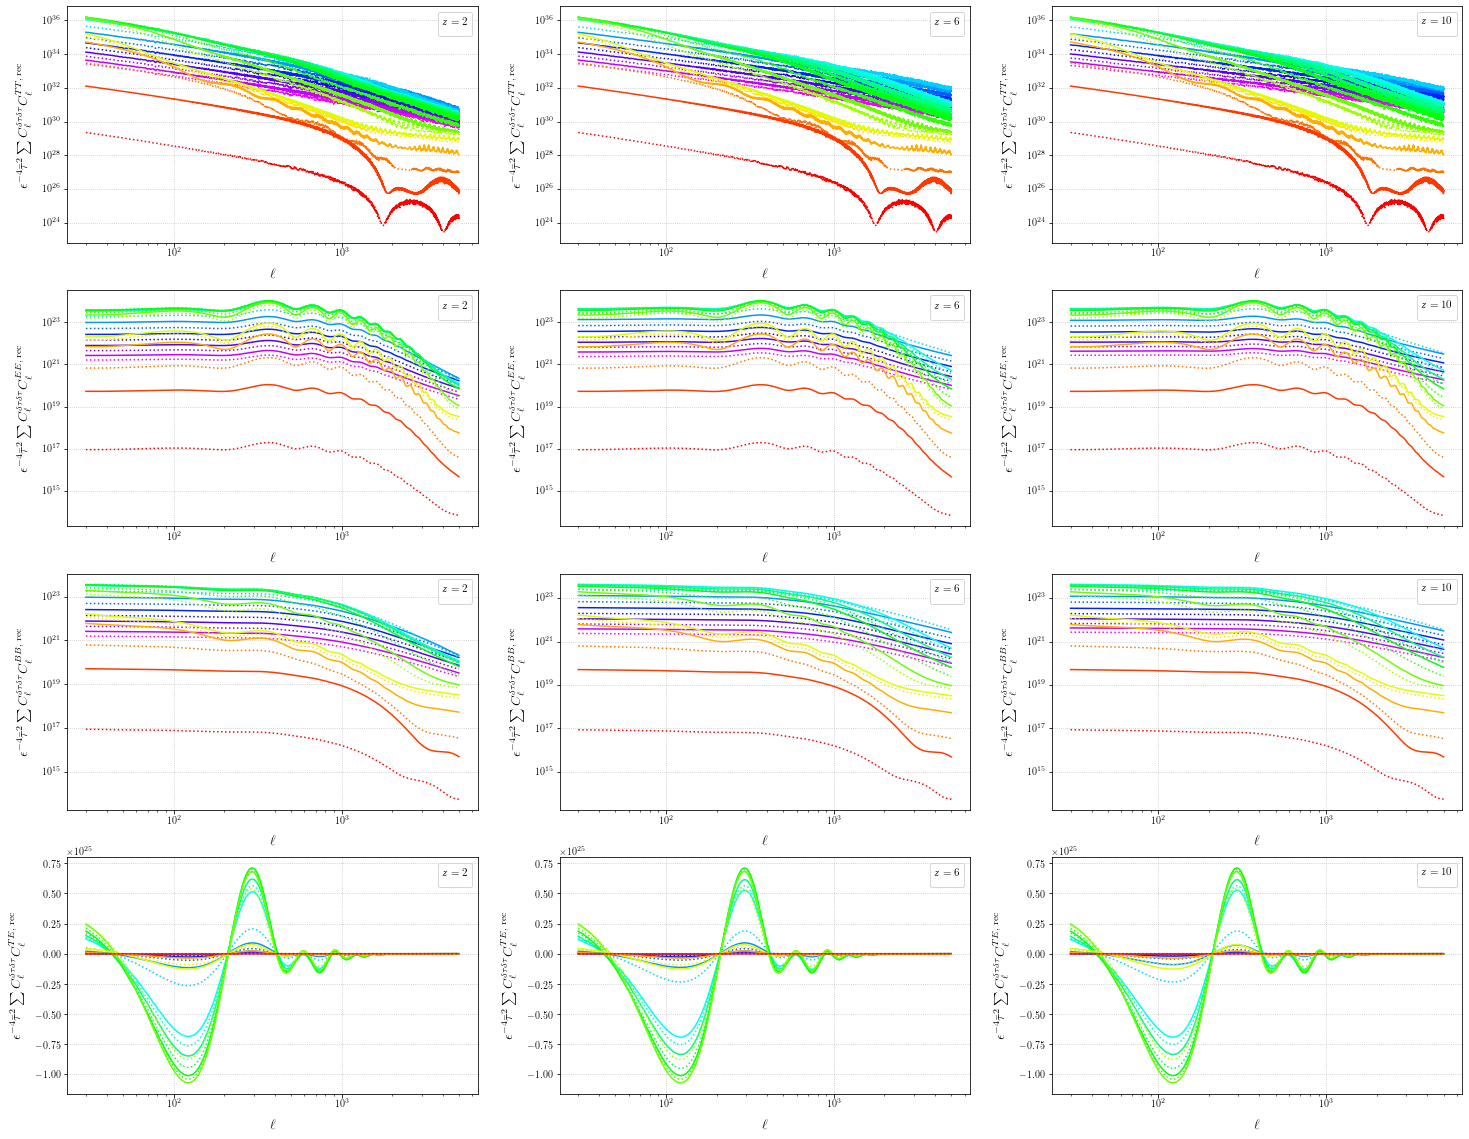

In [16]:
fig, ax = plt.subplots(4, len(ztype), figsize=(25, 20))
ylabel_list = [r'$C_{\ell}^{TT, \; {\rm rec}}$',r'$C_{\ell}^{EE, \; {\rm rec}}$',\
               r'$C_{\ell}^{BB, \; {\rm rec}}$',r'$C_{\ell}^{TE, \; {\rm rec}}$']
for zind, ztest in enumerate(ztype):
    lines = cycle(['-', ':'][::-1])

    for mind, MA in reversed(list(enumerate(dictKey))):
        lab1 = r'{}'.format(fmt(MA))
        lss = next(lines)
        alp = 0.3

        for ii in range(len(Screening[zind, mind])):
            ax[ii, zind].plot(ells[mm:mmm], Screening[zind, mind, ii, mm:mmm], color=cmap1(mind-1), ls=lss)

for zind, ztest in enumerate(ztype):
    for aa, axx in enumerate(ax[:,zind]):
       # axx.legend(ncol=3, title=r'${\rm Dark \; Photon \; Mass} \; m_A \; [{\rm eV}]$')
        axx.legend(title=r'$z=%5.0f$'%(int(ztest)))
        axx.set_xlabel(r'$\ell$')
        axx.set_ylabel(r'$\epsilon^{-4} \bar{\tau}^2 \sum C_{\ell}^{\delta\tau\delta\tau} $'+ylabel_list[aa])
        axx.set_xscale('log')
        axx.set_yscale(('log' if aa!=3 else 'linear'))
        axx.grid(ls=':', color='gray', alpha=0.5)
#plt.savefig('./plots/CMBdarkscreeningfullgrid.pdf', rasterize=True)
plt.show()


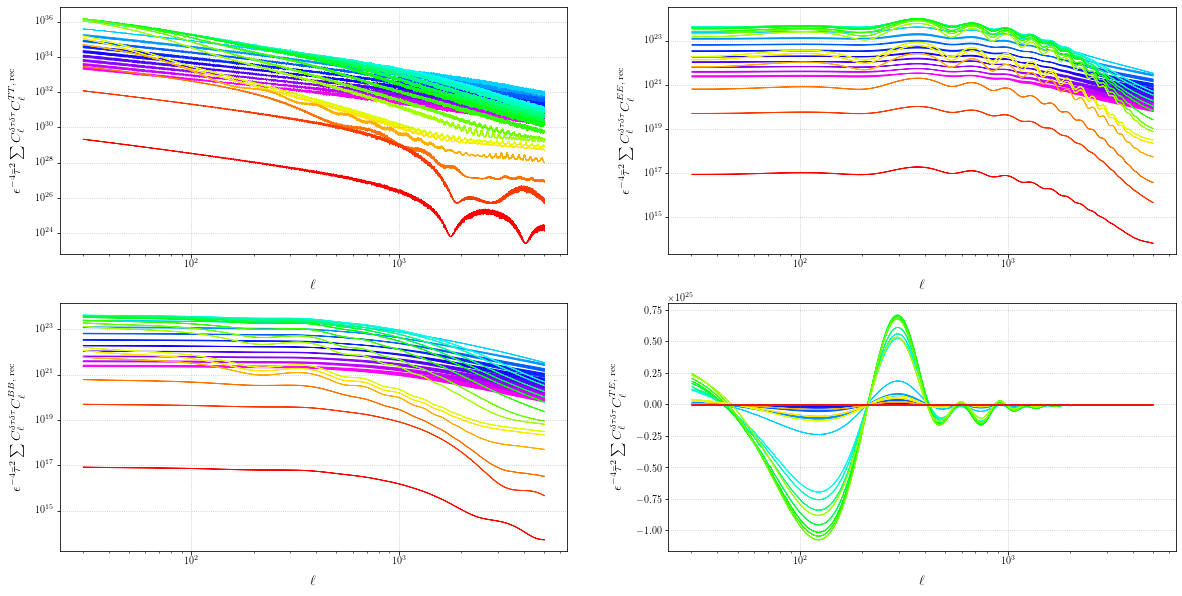

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
for mind, MA in reversed(list(enumerate(dictKey))):
    lab1 = r'{}'.format(fmt(MA))
    alp = 0.3

    for ii in range(len(Screening[zind, mind])):
        ax[np.divmod(ii,2)].fill_between(ells[mm:mmm], \
                                         Screening[1, mind, ii, mm:mmm],\
                                         Screening[2, mind, ii, mm:mmm], color=cmap1(mind-1))

for aa, axx in enumerate(ax.flatten()):
  #  axx.legend(ncol=3, title=r'${\rm Dark \; Photon \; Mass} \; m_A \; [{\rm eV}]$')
    axx.set_xlabel(r'$\ell$')
    axx.set_ylabel(r'$\epsilon^{-4} \bar{\tau}^2 \sum C_{\ell}^{\delta\tau\delta\tau} $'+ylabel_list[aa])
    axx.set_xscale('log')
    axx.set_yscale(('log' if aa!=3 else 'linear'))
    axx.grid(ls=':', color='gray', alpha=0.5)
#plt.savefig('./plots/screeningPS.pdf', rasterize=True)
plt.show()


/home/dpirvu/DarkPhoton/compute_power_spectra.py:221: RuntimeWarning: divide by zero encountered in divide
  WNoise = deltaT[frq] * ( 1. + (ells[2:]/lknee[frq])**aknee[frq] )
/home/dpirvu/DarkPhoton/compute_power_spectra.py:222: RuntimeWarning: overflow encountered in exp
  NellTT[2:, frq] = WNoise * np.exp(Beam)
/home/dpirvu/DarkPhoton/compute_power_spectra.py:221: RuntimeWarning: divide by zero encountered in divide
  WNoise = deltaT[frq] * ( 1. + (ells[2:]/lknee[frq])**aknee[frq] )
/home/dpirvu/DarkPhoton/compute_power_spectra.py:222: RuntimeWarning: overflow encountered in exp
  NellTT[2:, frq] = WNoise * np.exp(Beam)
/home/dpirvu/DarkPhoton/compute_power_spectra.py:221: RuntimeWarning: divide by zero encountered in divide
  WNoise = deltaT[frq] * ( 1. + (ells[2:]/lknee[frq])**aknee[frq] )
/home/dpirvu/DarkPhoton/compute_power_spectra.py:222: RuntimeWarning: overflow encountered in exp
  NellTT[2:, frq] = WNoise * np.exp(Beam)
/home/dpirvu/DarkPhoton/compute_power_spectra.py:221: R

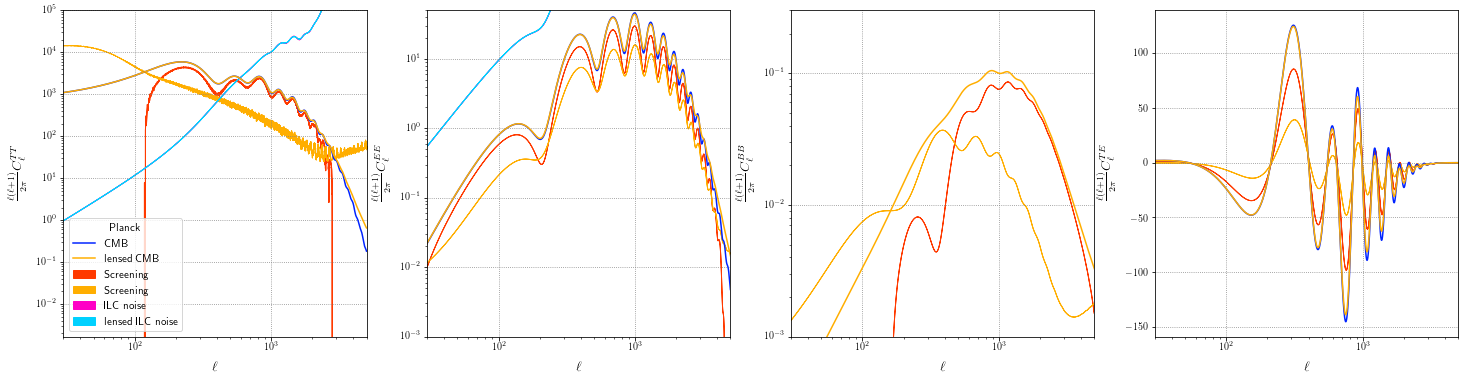

/tmp/ipykernel_65565/505117537.py:68: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim((0,100000))


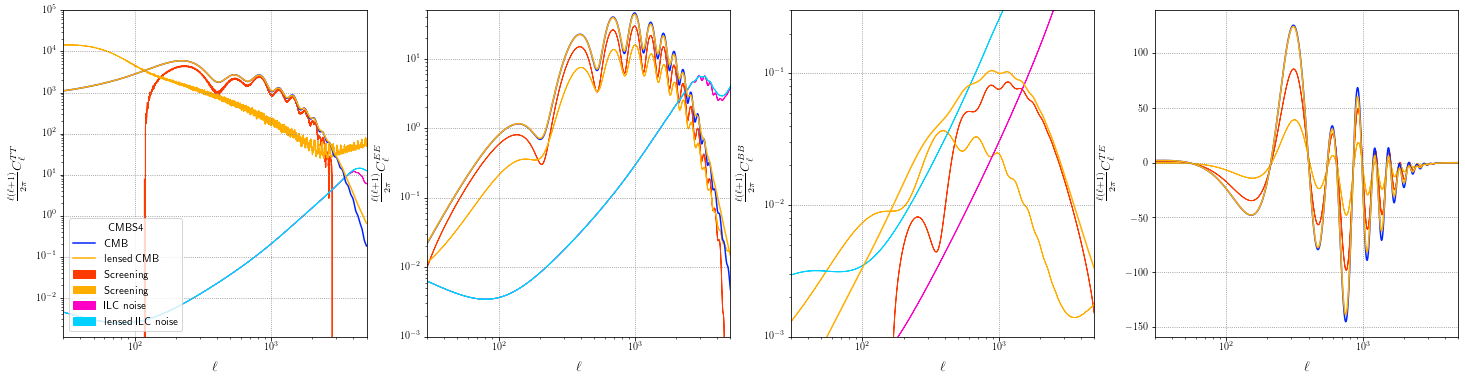

/tmp/ipykernel_65565/505117537.py:68: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim((0,100000))


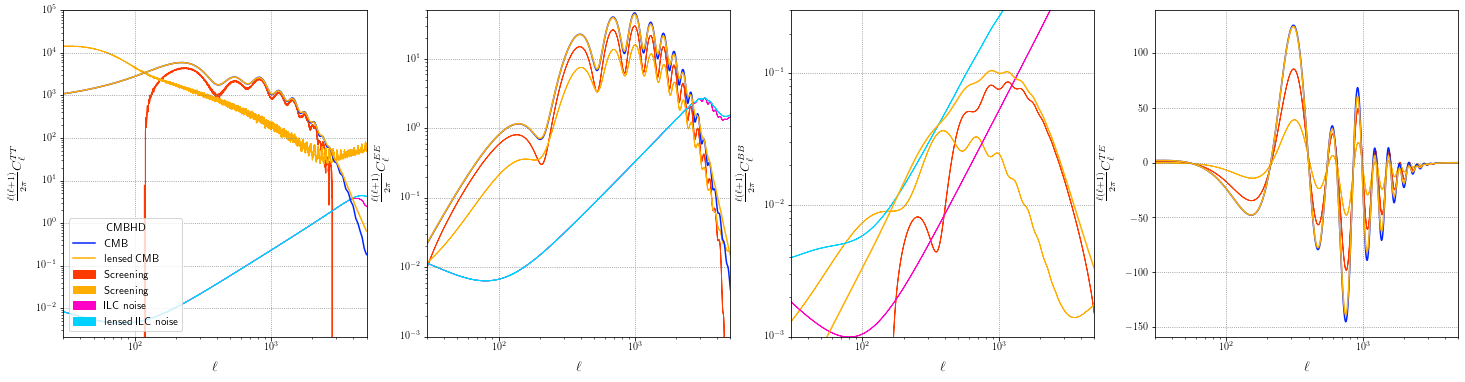

In [29]:
for expname, experiment in zip(['Planck', 'CMBS4', 'CMBHD'], [Planck, CMBS4, CMBHD]):
    if expname=='Planck':
        mm = 2
        mmm = 5000
    else:
        mm = 30
        mmm = 5000
    preqs = ells[mm:mmm]*(ells[mm:mmm]+1.)/2./np.pi

    fig, ax = plt.subplots(1,4, gridspec_kw={'width_ratios': [1, 1, 1, 1]}, figsize = (25,6))
    for ii in range(4):
        lssp = ['-', '--', ':']
        allp = [1, 0.6, 0.3]

        ax[ii].plot(ells[mm:mmm], preqs*(unlenCMB[mm:mmm, ii]), color=cmap1(17), label=('CMB' if ii==0 else None))
        ax[ii].plot(ells[mm:mmm], preqs*(lensedCMB[mm:mmm, ii]), color=cmap1(3), label=('lensed CMB' if ii==0 else None))
        freqs = experiment['freqsGHz']
        Nell  = noise(ells, experiment)
    #    for jj in range(len(freqs)):
    #        lab3 = ('{} GHz'.format(int(freqs[jj])) if ii==0 else None)
    #        ax[ii].plot(ells[mm:mmm], preqs*(unlenCMB[mm:mmm, ii]+Nell[ii, mm:mmm, jj]), color=cmap1(jj), alpha=1, ls=':', label=lab3)

        lab0 = ('Screening' if ii==0 else None)
        lab1 = ('ILC noise' if ii==0 else None)
        lab2 = ('lensed ILC noise' if ii==0 else None)

        if ii==0:
            epsilon = 3e-9    # TT
        elif ii==1 or ii==3:
            epsilon = 1.5e-7    # EE, TE
        elif ii==2:
            epsilon = 9e-8      # BB
        
        mind = 7
        
        if ii!=2:
            ax[ii].fill_between(ells[mm:mmm], preqs*(unlenCMB[mm:mmm, ii] - epsilon**4. * Screening[1, mind, ii, mm:mmm]), \
                                              preqs*(unlenCMB[mm:mmm, ii] - epsilon**4. * Screening[2, mind, ii, mm:mmm]), \
                                                      color=cmap1(1), ls='-', alpha=1, label=lab0)
        else:
            ax[ii].fill_between(ells[mm:mmm], preqs*(lensedCMB[mm:mmm, ii] - epsilon**4. * Screening[1, mind, ii, mm:mmm]), \
                                              preqs*(lensedCMB[mm:mmm, ii] - epsilon**4. * Screening[2, mind, ii, mm:mmm]), \
                                                      color=cmap1(1), ls='-', alpha=1, label=lab0)
        ax[ii].fill_between(ells[mm:mmm], preqs*(epsilon**4. * Screening[1, mind, ii, mm:mmm]), \
                                          preqs*(epsilon**4. * Screening[2, mind, ii, mm:mmm]), \
                                                  color=cmap1(3), ls='-', alpha=1, label=lab0)

        if ii<3:
            ILCnoise = np.load(nor0_ILCnoisePS_path(expname))
            ax[ii].fill_between(ells[mm:mmm], preqs*(ILCnoise[1, mind, ii, mm:mmm]), \
                                              preqs*(ILCnoise[2, mind, ii, mm:mmm]), color=cmap1(23), label=lab1)

            lend_ILCnoise = np.load(len_nor0_ILCnoisePS_path(expname))
            ax[ii].fill_between(ells[mm:mmm], preqs*(lend_ILCnoise[1, mind, ii, mm:mmm]), \
                                              preqs*(lend_ILCnoise[2, mind, ii, mm:mmm]), color=cmap1(14), label=lab2)

 #   lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
 #   lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
 #   fig.legend(lines, labels, loc='center right', title=expname)
    ax[0].legend(loc='lower left', title=expname)
    noiselab = [r'$C_\ell^{TT}$', r'$C_\ell^{EE}$', r'$C_\ell^{BB}$', r'$C_\ell^{TE}$']
    for ai, ax in enumerate(ax):
        ax.set_xlabel(r'$\ell$')
        ax.set_ylabel(r'$\frac{\ell(\ell+1)}{2 \pi}$'+noiselab[ai])
        if ai==0:
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_ylim((0,100000))
            ax.set_xlim(30,5001)
        elif ai==1:
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylim((1e-3,50))
            ax.set_xlim(30,5001)
        elif ai==2:
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylim((1e-3,0.3))
            ax.set_xlim(30,5001)
        else:
            ax.set_xscale('log')
            ax.set_xlim(30,5001)
            
        ax.grid(ls=':', color='gray')
    plt.savefig('./plots/comparisons'+str(expname)+'.pdf', rasterize=True)
    plt.show()

In [31]:
(arcmin2rad(1.)*np.asarray([10.41]))**2.

array([9.16966972e-06])

#### Contour Plot

(2, 24, 3, 2)


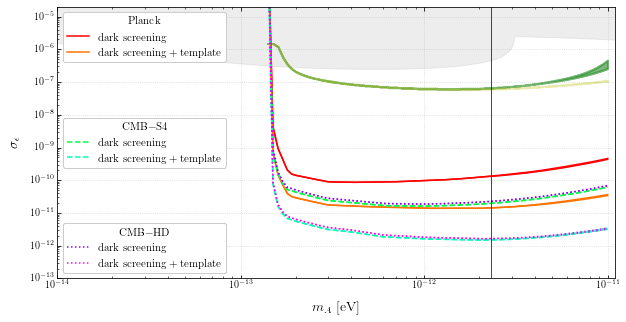

In [22]:
constraint = [r'$\rm dark \; screening$', \
              r'$\rm dark \; screening + template$', \
              r'$\rm template + reconstruction$']

jhdata = np.genfromtxt('./data/DPlimits.txt')

cmap = get_cmap(14)
fig, ax = plt.subplots(1,1, figsize = (10,5))

masslist_old = dictKey
masslist = np.linspace(masslist_old[0], masslist_old[-1], 1000)

datashape = np.shape(sigmaEpsilonList); print(datashape)

for eind, (expname, experiment) in enumerate(zip([r'$\rm Planck$', r'$\rm CMB{-}S4$', r'$\rm CMB{-}HD$'], [Planck, CMBS4, CMBHD])):
    secondary_lines, secondary_labels = [], []
    
    for method in range(datashape[-1]):
        lab = (expname)# if method==0 else None)
        has = ['/', '*', '+', '|'][method]
        col = cmap(5*eind+method)
        lss = ['-', '--', ':'][eind]

        ff = interpolate.interp1d(masslist_old, 1./sigmaEpsilonList[0, :, eind, method], kind='linear')
        gf = interpolate.interp1d(masslist_old, 1./sigmaEpsilonList[1, :, eind, method], kind='linear')

        plt.fill_between(masslist, 1./ff(masslist), 1./gf(masslist), color=col, alpha=0.)
        l1, = plt.plot(masslist, 1./ff(masslist), color=col, ls=lss)
        plt.plot(masslist, 1./gf(masslist), color=col, ls=lss)

        secondary_labels.append(constraint[method])
        secondary_lines.append(l1)

    ax.add_artist(plt.legend(secondary_lines, secondary_labels, title=expname, fancybox=True, framealpha=1, loc=[2,'center left',3][eind]))
plt.fill_between(jhdata[:,0], jhdata[:,1], np.ones(len(jhdata)), color='darkgray', alpha=0.2)

xvals, firasz6 = np.load('./data/FIRAScontour_CL99_reio6.npy')
xvals, firasz10 = np.load('./data/FIRAScontour_CL99_reio10.npy')
plt.fill_between(xvals, firasz6, firasz10, linewidth=2, alpha=0.6, color='forestgreen', label=r'FIRAS')

xvals, firasz6 = np.load('./data/nor0_FIRAScontour_CL99_reio6.npy')
xvals, firasz10 = np.load('./data/nor0_FIRAScontour_CL99_reio10.npy')
plt.fill_between(xvals, firasz6, firasz10, linewidth=2, alpha=0.3, color='y', label=r'FIRAS')

plt.axvline(MAMW_rscalelimit, ls='-', color='k', alpha=1, linewidth=0.7, label='MW')
#plt.legend(fancybox=True, framealpha=1, loc=1)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('both')
ax.tick_params(which='both', axis="y", direction="in")
ax.tick_params(which='both', axis="x", direction="in")

plt.xlim((1e-14, 1.1e-11))
plt.ylim((1e-13, 2e-5))
plt.ylabel(r'$\sigma_{\epsilon}$')
plt.xlabel(r'$m_A \; [{\rm eV}]$')
plt.xscale('log')
plt.yscale('log')

plt.grid(ls=':', color='darkgray', alpha=0.5)
#plt.savefig('./plots/contours.pdf', rasterize=True)
plt.show()
